# SMS Spam Classification

## Importing Necessary Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, when
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import col
import seaborn as sns


### Setup PySpark Environment

In [2]:
# Initialize a Spark session
spark = SparkSession.builder \
    .appName("SMS Spam Classification") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/02 00:12:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Preprocessing

Load the dataset, tokenize the text data, and split it into training and validation sets.

#### Load data using Pyspark

In [3]:
# Load the dataset
df = spark.read.csv('SMSSpamCollection', sep='\t', inferSchema=True, header=False)
df = df.withColumnRenamed('_c0', 'Label').withColumnRenamed('_c1', 'Message')

# Show the first few rows
df.show()

+-----+--------------------+
|Label|             Message|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
| spam|FreeMsg Hey there...|
|  ham|Even my brother i...|
|  ham|As per your reque...|
| spam|WINNER!! As a val...|
| spam|Had your mobile 1...|
|  ham|I'm gonna be home...|
| spam|SIX chances to wi...|
| spam|URGENT! You have ...|
|  ham|I've been searchi...|
|  ham|I HAVE A DATE ON ...|
| spam|XXXMobileMovieClu...|
|  ham|Oh k...i'm watchi...|
|  ham|Eh u remember how...|
|  ham|Fine if thats th...|
| spam|England v Macedon...|
+-----+--------------------+
only showing top 20 rows



### Visualizing the Label Distribution

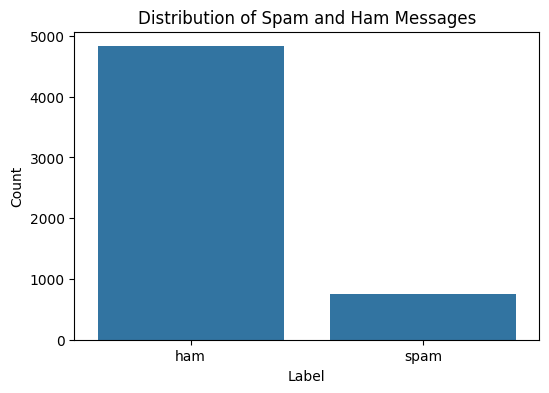

23/11/02 00:12:52 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas DataFrame for visualization
pdf = df.toPandas()

# Visualize the distribution of labels
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=pdf)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Data Preprocessing and Feature Engineering

In [5]:
# Convert 'ham'/'spam' labels to 0/1
df = df.withColumn('Label', when(col('Label') == 'spam', 1).otherwise(0))

# Text preprocessing pipeline
regexTokenizer = RegexTokenizer(inputCol="Message", outputCol="Words", pattern="\\W")
stopWordsRemover = StopWordsRemover(inputCol="Words", outputCol="Filtered")
hashingTF = HashingTF(inputCol="Filtered", outputCol="RawFeatures")
idf = IDF(inputCol="RawFeatures", outputCol="Features")

pipeline = Pipeline(stages=[regexTokenizer, stopWordsRemover, hashingTF, idf])

# Fit the pipeline to the data
model = pipeline.fit(df)
df = model.transform(df)

## Model Training

### Logistic Regeression

In [6]:
# Split the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the classifier
lr = LogisticRegression(featuresCol='Features', labelCol='Label')
lr_model = lr.fit(train_data)

# Predictions
predictions = lr_model.transform(test_data)

23/11/02 00:12:58 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:12:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/02 00:12:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
23/11/02 00:12:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:12:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:12:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:12:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:12:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:12:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:00 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 

### Model Evaluation

In [7]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Label')
accuracy = evaluator.evaluate(predictions)

print("Accuracy: ", accuracy)

23/11/02 00:13:07 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Accuracy:  0.9961789910769504


### More Metrics

In [8]:
# Convert the predictions to an RDD
predictions_rdd = predictions.select(col('Label').cast(FloatType()), col('prediction').cast(FloatType())).rdd

# Instantiate metrics object
metrics = BinaryClassificationMetrics(predictions_rdd)

# Area under precision-recall curve
print("Area under PR = %s" % metrics.areaUnderPR)

# Area under ROC curve
print("Area under ROC = %s" % metrics.areaUnderROC)

# Compute confusion matrix
tp = predictions[(predictions.Label == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.Label == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.Label == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.Label == 1) & (predictions.prediction == 0)].count()

# Calculate precision, recall, and F1-score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1_score)

/Users/bhanu/anaconda3/envs/DSP/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/11/02 00:13:10 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/02 00:13:11 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Area under PR = 0.8798215582529308
Area under ROC = 0.9766381766381766


23/11/02 00:13:11 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/02 00:13:12 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/02 00:13:12 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
23/11/02 00:13:12 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


Precision = 0.9703703703703703
Recall = 0.891156462585034
F1 Score = 0.9290780141843973


### Confusion Matrix

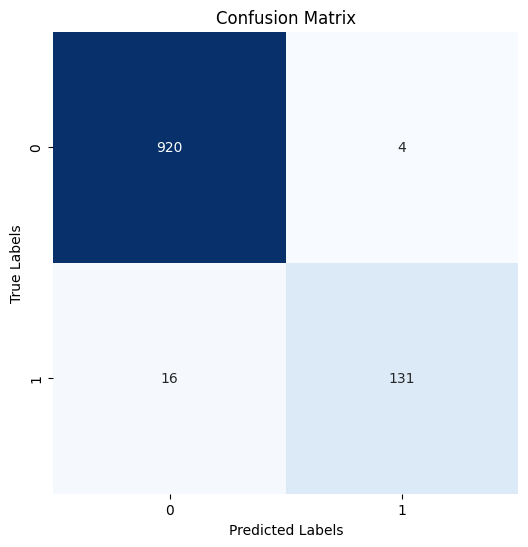

In [9]:
# Plot Confusion Matrix
confusion_matrix = [[tn, fp], [fn, tp]]

plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### SVM

In [10]:
from pyspark.ml.classification import LinearSVC

# Initialize and train the SVM classifier
svm = LinearSVC(featuresCol='Features', labelCol='Label', maxIter=10, regParam=0.1)
svm_model = svm.fit(train_data)

# Predictions
svm_predictions = svm_model.transform(test_data)

# Evaluate the model
svm_accuracy = evaluator.evaluate(svm_predictions)
print("SVM Accuracy: ", svm_accuracy)

23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:24 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:25 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
23/11/02 00:13:25 WARN DAGScheduler: Broadcasting larg

SVM Accuracy:  0.9970698236004358


In [11]:
from pyspark.sql.functions import col
import seaborn as sns

# Convert the predictions to an RDD
svm_predictions_rdd = svm_predictions.select(col('Label').cast(FloatType()), col('prediction').cast(FloatType())).rdd

# Instantiate metrics object
svm_metrics = BinaryClassificationMetrics(svm_predictions_rdd)

# Area under precision-recall curve
print("SVM Area under PR = %s" % svm_metrics.areaUnderPR)

# Area under ROC curve
print("SVM Area under ROC = %s" % svm_metrics.areaUnderROC)

# Compute confusion matrix
svm_tp = svm_predictions[(svm_predictions.Label == 1) & (svm_predictions.prediction == 1)].count()
svm_tn = svm_predictions[(svm_predictions.Label == 0) & (svm_predictions.prediction == 0)].count()
svm_fp = svm_predictions[(svm_predictions.Label == 0) & (svm_predictions.prediction == 1)].count()
svm_fn = svm_predictions[(svm_predictions.Label == 1) & (svm_predictions.prediction == 0)].count()

# Calculate precision, recall, and F1-score
svm_precision = svm_tp / (svm_tp + svm_fp)
svm_recall = svm_tp / (svm_tp + svm_fn)
svm_f1_score = 2 * (svm_precision * svm_recall) / (svm_precision + svm_recall)

print("SVM Precision = %s" % svm_precision)
print("SVM Recall = %s" % svm_recall)
print("SVM F1 Score = %s" % svm_f1_score)

/Users/bhanu/anaconda3/envs/DSP/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
23/11/02 00:13:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/11/02 00:13:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


SVM Area under PR = 0.9016287366010235
SVM Area under ROC = 0.9722717913520934


23/11/02 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/11/02 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
23/11/02 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


SVM Precision = 0.9574468085106383
SVM Recall = 0.9183673469387755
SVM F1 Score = 0.9375000000000001


23/11/02 00:13:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


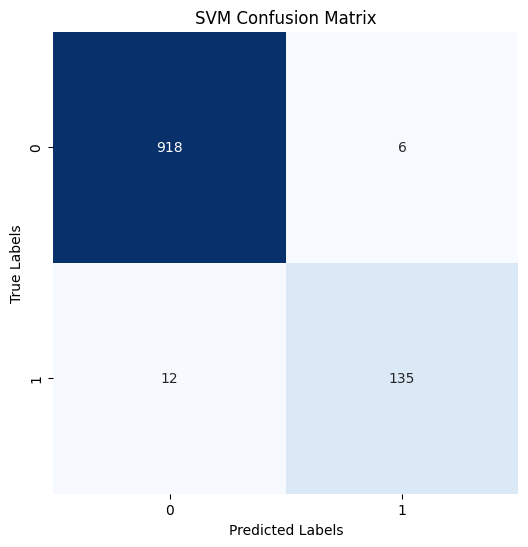

In [12]:
# Plot Confusion Matrix
svm_confusion_matrix = [[svm_tn, svm_fp], [svm_fn, svm_tp]]

plt.figure(figsize=(6,6))
sns.heatmap(svm_confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()